## Mercedes logo or not?

In [33]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [34]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search --use-deprecated=legacy-resolver

## Step 1: Download images of mercedes and porsche logos

In [35]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a mercedes logo photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [36]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('mercedes logo photos', max_images=1)
urls[0]

Searching for 'mercedes logo photos'


'http://wallpapercave.com/wp/wp1846638.jpg'

...and then download a URL and take a look at it:

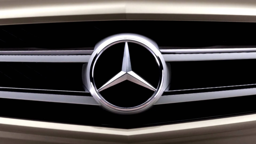

In [37]:
from fastdownload import download_url
dest = 'mercedes.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'porsche logo photos'


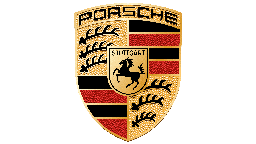

In [46]:
dest = 'porsche.jpg'
urls = search_images('porsche logo photos', max_images=2)
download_url(urls[1], dest, show_progress=False)
Image.open('porsche.jpg').to_thumb(256,256)

In [47]:
searches = 'mercedes','porsche'
path = Path('mercedes_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} logo photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} old logo photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} new logo photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'mercedes logo photo'
Searching for 'mercedes old logo photo'
Searching for 'mercedes new logo photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'porsche logo photo'
Searching for 'porsche old logo photo'
Searching for 'porsche new logo photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [48]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

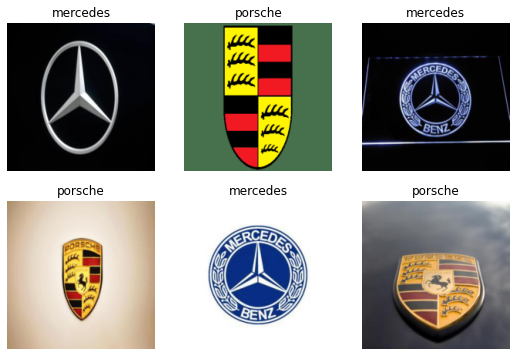

In [49]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [50]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.583356,0.082654,0.028571,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.137491,0.010272,0.000000,00:02
1,0.077690,0.000286,0.000000,00:01
2,0.051117,0.000112,0.000000,00:01


## Step 3: Use the model

Let's see what our model thinks about that mercedes logo image we downloaded at the start:

In [51]:
is_mercedes,_,probs = learn.predict('mercedes.jpg')
print(f"This is a: {is_mercedes}.")
print(f"Probability it's a mercedes logo: {probs[0]:.4f}")

This is a: mercedes.
Probability it's a mercedes logo: 1.0000
